In [1]:
# benchmarking the non-balanced strategies for comparison
# -NEI
# -TEAD
# -TuRBO
# - Sobol
# Author: Alex Braafladt
# Created 2/23/2023
# Notes:

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from extremasearch.globalmm.globalsearch import MultimodalExtremaSearch
from botorch import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np
import networkx as nx
from botorch.models.transforms import Normalize, Standardize


# setup
dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
def mme_torch(x):
    x = x
    y = torch.zeros(x.shape)
    y += 0.66*(-1.*x + 0.1*torch.sin(30.*x) + torch.exp(-(100.*(x-0.65))**2.))
    y += 0.5 * ( torch.exp(-(100.*(x-0.35))**2.) )
    y += 0.4 * ( torch.exp(-(100.*(x-0.92))**2.) )
    y += 0.73
    return y

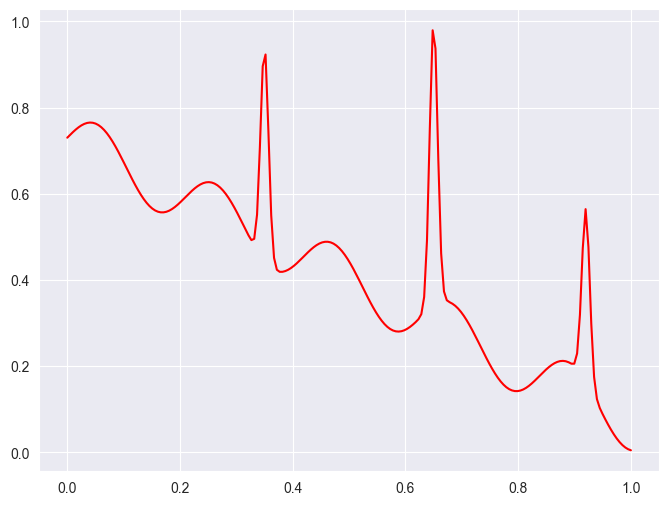

In [4]:
x1 = torch.linspace(0,1.0,200)
y1 = mme_torch(x1)
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.lineplot(x=x1, y=y1, ax=ax, color='r')
None

<AxesSubplot: >

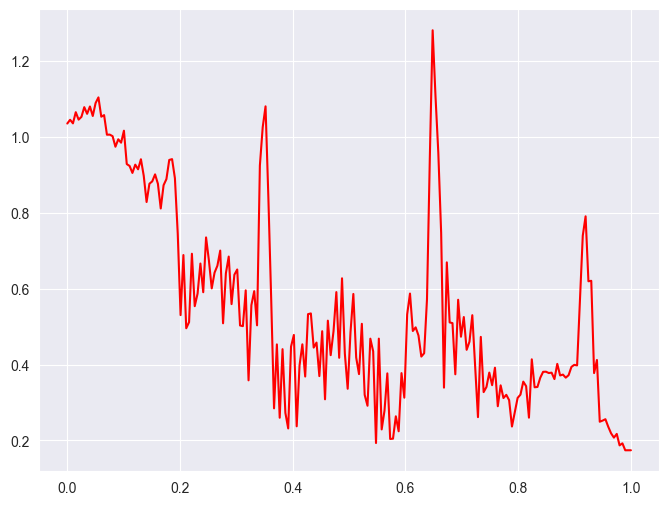

In [5]:
def mme_noise_jump_1d_mean(x):
    y = torch.zeros(x.shape)
    y += 0.66*(-1.*x + 0.1*torch.sin(30.*x) + torch.exp(-(100.*(x-0.65))**2.)) * (x >= 0.6)
    y += 0.66*(-1.*x + 0.1*torch.sin(30.*x) - 0.25 + torch.exp(-(100.*(x-0.65))**2.)) * (x < 0.6) * (x >= 0.2)
    y += 0.66*(-1.*x + 0.1*torch.sin(30.*x) + 0.2 + torch.exp(-(100.*(x-0.65))**2.)) * (x < 0.2)
    y += 0.7 * ( torch.exp(-(100.*(x-0.35))**2.) )
    y += 0.4 * ( torch.exp(-(100.*(x-0.92))**2.) )
    y += 0.9
    return y


sigma_max = 0.12
sigma_min = 0.02


def mme_noise_jump_1d(x):
    # mean
    y = mme_noise_jump_1d_mean(x)
    # noise
    noise = torch.zeros(x.shape)
    noise += (torch.randn(x.shape) * sigma_max) * (x >= 0.61) * (x < 0.71)
    noise += (torch.randn(x.shape) * 0.5*sigma_max) * (x >= 0.31) * (x < 0.41)
    noise += (torch.randn(x.shape) * 0.8*sigma_max) * (x >= 0.90) * (x < 0.94)
    noise += (torch.randn(x.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x-0.2))) )* (x < 0.61)
    noise += (torch.randn(x.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x-0.75))) ) * (x >= 0.71)
    # combined
    y_out = y + noise
    # any_neg = y_out < 0
    # if any_neg:
    #     y_out = torch.tensor(0.0)
    return y_out


x1 = torch.linspace(0,1.0,200)
y1 = mme_noise_jump_1d(x1)
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.lineplot(x=x1, y=y1, ax=ax, color='r')

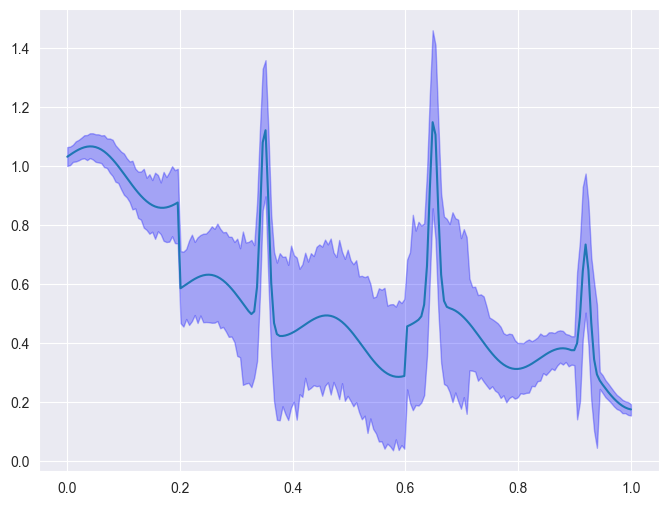

In [6]:
# plot noise bounds as 99% confidence interval
# generate realizations of the function
num_reals = 500
num_x = 200
x1 = torch.linspace(0,1.0,num_x)
y_reps = torch.DoubleTensor(num_x, num_reals)
y_deter = mme_noise_jump_1d_mean(x1)
for i in range(num_reals):
    y_reps[:,i] = mme_noise_jump_1d(x1)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.lineplot(x=x1, y=y_deter, ax=ax)
upper_99 = torch.quantile(y_reps, 0.995, dim=1)
lower_01 = torch.quantile(y_reps, 0.005, dim=1)
ax.fill_between(x1, lower_01, upper_99, color='b', alpha=0.3, label=r'99% quantiles')
# plt.savefig(datasavedir + '/'+'up_nonstat_function_fill'+'.png')

In [7]:
def outcome_objective(x):
    """wrapper for the outcome objective function"""
    # return mme_torch(X).type_as(X)
    return mme_noise_jump_1d(x).type_as(x)

In [8]:
# set up the GP model for use
def initialize_model(train_x, train_obj, state_dict=None):
    """function to initialize the GP model"""
    model_obj = SingleTaskGP(train_x, train_obj)
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    # load state_dict if it is not passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return mll, model_obj

# set up the initial data set
def generate_initial_data(n=10):
    """generate initial set of data to get started with BO loop"""
    train_x = torch.rand(10, 1, device=device, dtype=dtype)
    exact_obj = outcome_objective(train_x)
    # train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    train_obj = exact_obj
    best_observed_value = exact_obj.max().item()
    return train_x, train_obj, best_observed_value

from botorch.optim import optimize_acqf
NUM_RESTARTS = 10
RAW_SAMPLES = 512
bounds = torch.tensor([0.0, 1.0], device=device, dtype=dtype).unsqueeze(-1)
def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation"""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,# initialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    new_x = candidates.detach()
    exact_obj = outcome_objective(new_x)
    # new_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    new_obj = exact_obj
    return new_x, new_obj

def update_random_observation():
    """Simulates a random policy by taking the current list of best values observed
    randomly, drawing a new random point, observing its value, and updating the list
    """
    rand_x = torch.rand(BATCH_SIZE, 1)  # drawing from random uniform
    next_random_best = outcome_objective(rand_x)
    return  rand_x, next_random_best

In [9]:
from extremasearch.acquisition.turbo import NewTurboState, new_update_state, generate_batch
from extremasearch.acquisition.tead import global_tead
import time
from botorch.sampling import SobolQMCNormalSampler
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from extremasearch.local.localsearch import initialize_scaled_model

N_TRIALS = 1
N_BATCH = 100
MC_SAMPLES = 256
N_CANDIDATES = min(5000, max(2000, 200 * 1))
BATCH_SIZE = 1

verbose = True
import warnings
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# set up arrays to hold arrays of data
best_observed_all_nei, best_observed_random_all, best_observed_all_tead = [], [], []
best_observed_all_turbo = []

# going to average over N_TRIALS
for trial in range(1, N_TRIALS + 1):
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    # set up arrays to hold data for this trial
    best_observed_nei, best_observed_random, best_observed_tead = [], [], []
    best_observed_turbo = []

    # generate initial training data and initial model for this trial
    # nei
    # use same initial training points
    train_x_nei, train_obj_nei, best_observed_value_nei = generate_initial_data(n=10)
    mll_nei, model_nei = initialize_model(train_x_nei, train_obj_nei)
    # tead
    # use same initial points
    train_x_tead, train_obj_tead = train_x_nei, train_obj_nei
    best_observed_value_tead = best_observed_value_nei
    mll_tead, model_tead = initialize_model(train_x_tead, train_obj_tead)
    # turbo
    train_x_turbo, train_obj_turbo = train_x_nei, train_obj_nei
    best_observed_value_turbo = best_observed_value_nei
    # turbo initialization
    state = NewTurboState(dim=1, batch_size=BATCH_SIZE, center=torch.tensor(0.5), lb=torch.tensor(0.0), ub=torch.tensor(1.0))
    state = new_update_state(state, train_x_turbo, train_obj_turbo, torch.DoubleTensor([best_observed_value_turbo]))
    tr_x_turbo, tr_obj_turbo = state.get_training_samples_in_region()
    mll_turbo, model_turbo = initialize_scaled_model(tr_x_turbo, tr_obj_turbo)
    # random
    train_x_random, train_obj_random = train_x_nei, train_obj_nei

    # start collection of results from random initialization
    best_observed_nei.append(best_observed_value_nei)
    best_observed_random.append(best_observed_value_nei)
    best_observed_tead.append(best_observed_value_tead)
    best_observed_turbo.append(best_observed_value_turbo)

    # for N_BATCH rounds of BO after the initial random batch
    for iteration in range(1, N_BATCH + 1):
        t0 = time.monotonic()
        # fit models
        fit_gpytorch_mll(mll_nei)
        fit_gpytorch_mll(mll_tead)
        fit_gpytorch_mll(mll_turbo)

        # set up the sampler to use with the acq funcs
        qmc_sampler = SobolQMCNormalSampler(sample_shape=MC_SAMPLES)

        # set up the acquisition functions
        qNEI = qNoisyExpectedImprovement(
            model=model_nei,
            X_baseline=train_x_nei,
            sampler=qmc_sampler,
        )

        # optimize the acquisition functions
        new_x_nei, new_obj_nei = optimize_acqf_and_get_observation(qNEI)
        new_x_tead = global_tead(model_tead)
        new_obj_tead = outcome_objective(new_x_tead)
        new_x_turbo = generate_batch(
            state=state,
            model=model_turbo,
            # x=train_x_turbo,
            x=state.train_x,
            # y=train_obj_turbo,
            y=state.train_y,
            batch_size=BATCH_SIZE,
            n_candidates=N_CANDIDATES,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            acqf='ts',
            # acqf='ei',
        )
        new_obj_turbo = outcome_objective(new_x_turbo)
        # random
        new_x_random, new_obj_random = update_random_observation()

        # update training points
        train_x_nei = torch.cat([train_x_nei, new_x_nei])
        train_obj_nei = torch.cat([train_obj_nei, new_obj_nei])
        train_x_tead = torch.cat([train_x_tead, new_x_tead])
        train_obj_tead = torch.cat([train_obj_tead, new_obj_tead])
        train_x_turbo = torch.cat([train_x_turbo, new_x_turbo])
        train_obj_turbo = torch.cat([train_obj_turbo, new_obj_turbo])
        train_x_random = torch.cat([train_x_random, new_x_random])
        train_obj_random = torch.cat([train_obj_random, new_obj_random])

        # update trust region
        state = new_update_state(state, x_train=train_x_turbo, y_train=train_obj_turbo, y_next=new_obj_turbo)

        # update progress data
        best_value_random = train_obj_random.max()
        best_observed_random.append(best_value_random)
        best_value_nei = train_obj_nei.max()
        best_observed_nei.append(best_value_nei)
        best_value_tead = train_obj_tead.max()
        best_observed_tead.append(best_value_tead)
        best_value_turbo = train_obj_turbo.max()
        best_observed_turbo.append(best_value_turbo)

        # reinitialize the models so that they're ready to fit on the next iteration
        # state dict passed to speed up fitting
        mll_nei, model_nei = initialize_model(
            train_x_nei,
            train_obj_nei,
            model_nei.state_dict(),
        )
        mll_tead, model_tead = initialize_model(
            train_x_tead,
            train_obj_tead,
            model_tead.state_dict(),
        )
        # update trust region model
        tr_x_turbo, tr_obj_turbo = state.get_training_samples_in_region()
        mll_turbo, model_turbo = initialize_scaled_model(tr_x_turbo, tr_obj_turbo)

        t1 = time.monotonic()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qNEI, TEAD, TuRBO) = "
                f"({best_value_random:>4.2f}, {best_value_nei:>4.2f}, {best_value_tead:>4.2f}, {state.best_value:>4.2f}), "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")

    # collect observations from trial
    best_observed_all_nei.append(best_observed_nei)
    best_observed_random_all.append(best_observed_random)
    best_observed_all_tead.append(best_observed_tead)
    best_observed_all_turbo.append(best_observed_turbo)


Trial  1 of 1 
Batch  1: best_value (random, qNEI, TEAD, TuRBO) = (1.17, 1.17, 1.17, 1.17), time = 9.45.
Batch  2: best_value (random, qNEI, TEAD, TuRBO) = (1.18, 1.17, 1.17, 1.17), time = 11.20.
Batch  3: best_value (random, qNEI, TEAD, TuRBO) = (1.18, 1.17, 1.17, 1.17), time = 9.47.
Batch  4: best_value (random, qNEI, TEAD, TuRBO) = (1.18, 1.17, 1.17, 1.17), time = 7.34.
Batch  5: best_value (random, qNEI, TEAD, TuRBO) = (1.18, 1.17, 1.17, 1.17), time = 6.64.
Batch  6: best_value (random, qNEI, TEAD, TuRBO) = (1.18, 1.17, 1.17, 1.17), time = 10.42.
Batch  7: best_value (random, qNEI, TEAD, TuRBO) = (1.18, 1.17, 1.17, 1.17), time = 7.39.
Batch  8: best_value (random, qNEI, TEAD, TuRBO) = (1.18, 1.17, 1.17, 1.17), time = 7.58.
Batch  9: best_value (random, qNEI, TEAD, TuRBO) = (1.18, 1.17, 1.17, 1.17), time = 9.30.
Batch 10: best_value (random, qNEI, TEAD, TuRBO) = (1.18, 1.17, 1.17, 1.17), time = 8.70.
Batch 11: best_value (random, qNEI, TEAD, TuRBO) = (1.18, 1.17, 1.17, 1.17), time 

In [25]:
# abbreviated QMC loop with Sobol sequences
from torch.quasirandom import SobolEngine

best_observed_all_sobol = []
for trial in range(1, N_TRIALS + 1):
    print(f"\nSobol Trial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_sobol = []
    # get sobol random samples for the trial
    X_Sobol = SobolEngine(1, scramble=True).draw(N_BATCH+10).to(dtype=dtype, device=device)
    Y_Sobol = torch.tensor([outcome_objective(x) for x in X_Sobol], dtype=dtype, device=device).unsqueeze(-1)
    curMax = torch.max(Y_Sobol[:10])
    for y_val in Y_Sobol[10:]:
        curMax = torch.max(curMax,y_val)
        best_observed_sobol.append(curMax.squeeze())
    best_observed_all_sobol.append(best_observed_sobol)


Sobol Trial  1 of 1 

In [26]:
y_tead = np.asarray(best_observed_all_tead)
y_sobol = np.asarray(best_observed_all_sobol)

In [27]:
fit_gpytorch_mll(mll_nei)
fit_gpytorch_mll(mll_tead)
fit_gpytorch_mll(mll_turbo)
None

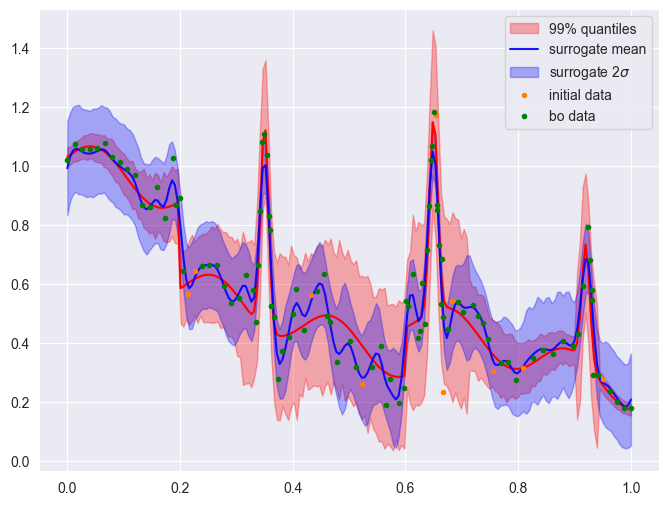

In [28]:
# plot the results for tead
x_test = torch.linspace(0,1,200)
f, ax = plt.subplots(1,1, figsize=(8, 6))
# true objective
# true objective
# ax.plot(x_test.numpy(), outcome_objective(x_test).numpy(), 'r-', alpha=0.9, label='true objective')
sns.lineplot(x=x1, y=y_deter, ax=ax, color='r')
upper_99 = torch.quantile(y_reps, 0.995, dim=1)
lower_01 = torch.quantile(y_reps, 0.005, dim=1)
ax.fill_between(x1, lower_01, upper_99, color='r', alpha=0.3, label=r'99% quantiles')
# final model
mean_test = model_tead.posterior(x_test.unsqueeze(-1)).mean.detach().numpy()
ax.plot(x_test.numpy(), mean_test, 'b-', alpha=0.9, label='surrogate mean')
var_test = model_tead.posterior(x_test.unsqueeze(-1)).variance.detach().numpy()
sd_test = np.sqrt(var_test)
upper_test = mean_test + 2.0*sd_test
lower_test = mean_test - 2.0*sd_test
ax.fill_between(x_test.numpy(), lower_test.squeeze(), upper_test.squeeze(), color='b', alpha=0.3, label=r'surrogate 2$\sigma$')
# training points
ax.plot(train_x_tead.numpy()[0:10], train_obj_tead[0:10].numpy(), '.', color='tab:orange', label='initial data')
ax.plot(train_x_tead.numpy()[10:], train_obj_tead[10:].numpy(), '.', color='g', label='bo data')
ax.legend()
None

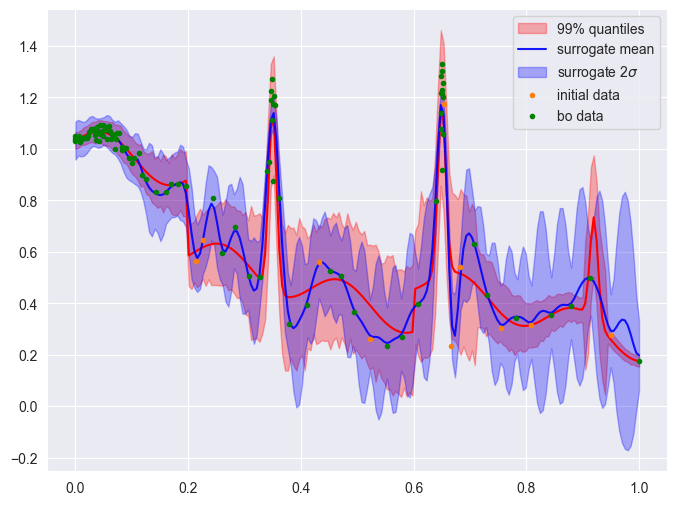

In [29]:
# plot the results for nei
x_test = torch.linspace(0,1,200)
f, ax = plt.subplots(1,1, figsize=(8, 6))
# true objective
# true objective
# ax.plot(x_test.numpy(), outcome_objective(x_test).numpy(), 'r-', alpha=0.9, label='true objective')
sns.lineplot(x=x1, y=y_deter, ax=ax, color='r')
upper_99 = torch.quantile(y_reps, 0.995, dim=1)
lower_01 = torch.quantile(y_reps, 0.005, dim=1)
ax.fill_between(x1, lower_01, upper_99, color='r', alpha=0.3, label=r'99% quantiles')
# final model
mean_test = model_nei.posterior(x_test.unsqueeze(-1)).mean.detach().numpy()
ax.plot(x_test.numpy(), mean_test, 'b-', alpha=0.9, label='surrogate mean')
var_test = model_nei.posterior(x_test.unsqueeze(-1)).variance.detach().numpy()
sd_test = np.sqrt(var_test)
upper_test = mean_test + 2.0*sd_test
lower_test = mean_test - 2.0*sd_test
ax.fill_between(x_test.numpy(), lower_test.squeeze(), upper_test.squeeze(), color='b', alpha=0.3, label=r'surrogate 2$\sigma$')
# training points
ax.plot(train_x_nei.numpy()[0:10], train_obj_nei[0:10].numpy(), '.', color='tab:orange', label='initial data')
ax.plot(train_x_nei.numpy()[10:], train_obj_nei[10:].numpy(), '.', color='g', label='bo data')
ax.legend()
None

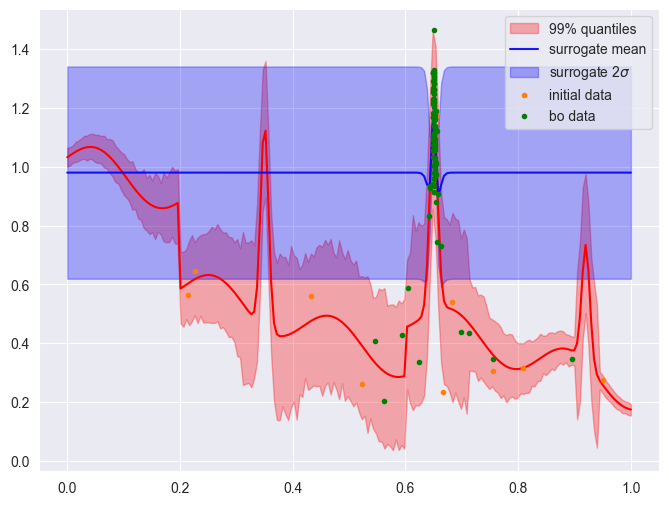

In [30]:
# plot the results for turbo
x_test = torch.linspace(0,1,200)
f, ax = plt.subplots(1,1, figsize=(8, 6))
# true objective
sns.lineplot(x=x1, y=y_deter, ax=ax, color='r')
upper_99 = torch.quantile(y_reps, 0.995, dim=1)
lower_01 = torch.quantile(y_reps, 0.005, dim=1)
ax.fill_between(x1, lower_01, upper_99, color='r', alpha=0.3, label=r'99% quantiles')
# final model
mean_test = model_turbo.posterior(x_test.unsqueeze(-1)).mean.detach().numpy()
ax.plot(x_test.numpy(), mean_test, 'b-', alpha=0.9, label='surrogate mean')
var_test = model_turbo.posterior(x_test.unsqueeze(-1)).variance.detach().numpy()
sd_test = np.sqrt(var_test)
upper_test = mean_test + 2.0*sd_test
lower_test = mean_test - 2.0*sd_test
ax.fill_between(x_test.numpy(), lower_test.squeeze(), upper_test.squeeze(), color='b', alpha=0.3, label=r'surrogate 2$\sigma$')
# training points
ax.plot(train_x_turbo.numpy()[0:10], train_obj_turbo[0:10].numpy(), '.', color='tab:orange', label='initial data')
ax.plot(train_x_turbo.numpy()[10:], train_obj_turbo[10:].numpy(), '.', color='g', label='bo data')
ax.legend()
None

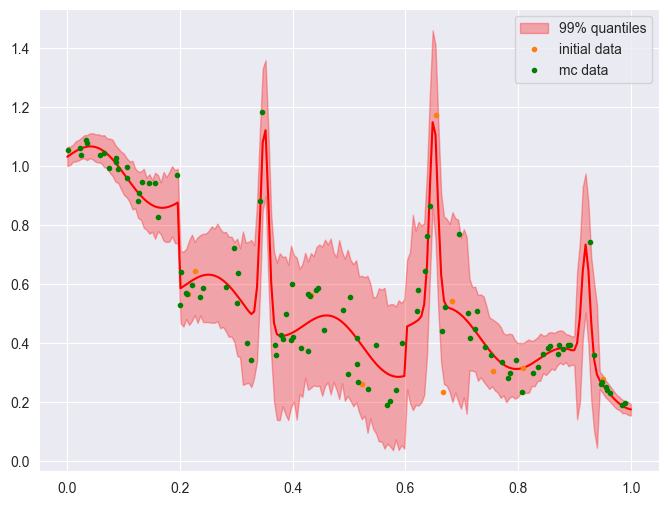

In [31]:
# plot the results for random
x_test = torch.linspace(0,1,200)
f, ax = plt.subplots(1,1, figsize=(8, 6))
# true objective
sns.lineplot(x=x1, y=y_deter, ax=ax, color='r')
upper_99 = torch.quantile(y_reps, 0.995, dim=1)
lower_01 = torch.quantile(y_reps, 0.005, dim=1)
ax.fill_between(x1, lower_01, upper_99, color='r', alpha=0.3, label=r'99% quantiles')
# training points
ax.plot(train_x_random.numpy()[0:10], train_obj_random[0:10].numpy(), '.', color='tab:orange', label='initial data')
ax.plot(train_x_random.numpy()[10:], train_obj_random[10:].numpy(), '.', color='g', label='mc data')
ax.legend()
None

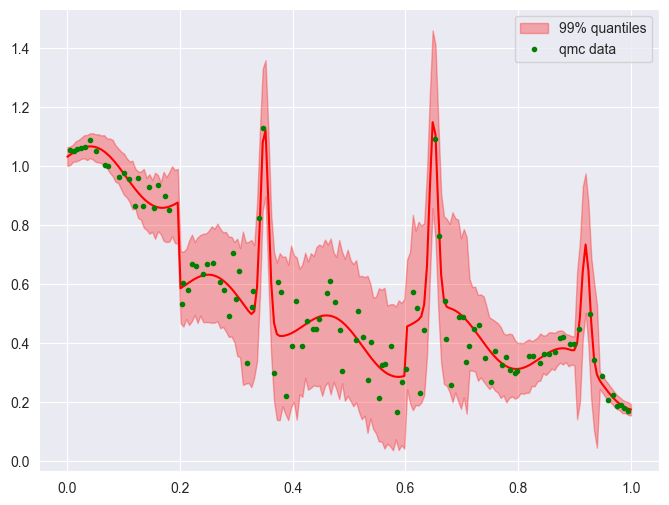

In [32]:
# plot the results for qmc
x_test = torch.linspace(0,1,200)
f, ax = plt.subplots(1,1, figsize=(8, 6))
# true objective
sns.lineplot(x=x1, y=y_deter, ax=ax, color='r')
upper_99 = torch.quantile(y_reps, 0.995, dim=1)
lower_01 = torch.quantile(y_reps, 0.005, dim=1)
ax.fill_between(x1, lower_01, upper_99, color='r', alpha=0.3, label=r'99% quantiles')
# training points
ax.plot(X_Sobol.numpy(), Y_Sobol.numpy(), '.', color='g', label='qmc data')
ax.legend()
None

In [33]:
# algorithms for multi-modal optimization metrics
def count_number_peaks_observed(x_obs, y_obs, num_known_peaks=4):
    """Function to count the number of peaks observed for the mme_noise_jump_1d function"""
    peak1, peak2, peak3, peak4 = False, False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.03 <= x <= 0.07:
            if y >= 1.065:
                peak1 = True
        elif 0.345 <= x <= 0.355:
            if y >= 1.12:
                peak2 = True
        elif 0.645 <= x <= 0.655:
            if y >= 1.145:
                peak3 = True
        elif 0.915 <= x <= 0.925:
            if y >= 0.734:
                peak4 = True
    num_peaks_observed = peak1 + peak2 + peak3 + peak4
    return num_peaks_observed

def count_evaluations_for_all_peaks(x_obs, y_obs):
    """Count the number of function evaluations before finding all peaks"""
    i = 0
    num_evals_for_all_peaks = x_obs.shape[0]
    peak1, peak2, peak3, peak4 = False, False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.03 <= x <= 0.07:
            if y >= 1.065:
                peak1 = True
        elif 0.345 <= x <= 0.355:
            if y >= 1.12:
                peak2 = True
        elif 0.645 <= x <= 0.655:
            if y >= 1.145:
                peak3 = True
        elif 0.915 <= x <= 0.925:
            if y >= 0.734:
                peak4 = True
        i += 1
        if peak1 and peak2 and peak3 and peak4:
            num_evals_for_all_peaks = i
            break
    return num_evals_for_all_peaks

In [34]:
# calculate and print metrics
x_sob, y_sob = X_Sobol, Y_Sobol
x_nei, y_nei = train_x_nei, train_obj_nei
x_ran, y_ran = train_x_random, train_obj_random
x_tea, y_tea = train_x_tead, train_obj_tead
x_tur, y_tur = train_x_turbo, train_obj_turbo

print('Random: peaks {num}, evaluations for all {evals}'.format(num=count_number_peaks_observed(x_ran, y_ran),
                                                                evals=count_evaluations_for_all_peaks(x_ran, y_ran)))
print('Sobol: peaks {num}, evaluations for all {evals}'.format(num=count_number_peaks_observed(x_sob, y_sob),
                                                               evals=count_evaluations_for_all_peaks(x_sob, y_sob)))
print('NEI: peaks {num}, evaluations for all {evals}'.format(num=count_number_peaks_observed(x_nei, y_nei),
                                                                evals=count_evaluations_for_all_peaks(x_nei, y_nei)))
print('TuRBO: peaks {num}, evaluations for all {evals}'.format(num=count_number_peaks_observed(x_tur, y_tur),
                                                                evals=count_evaluations_for_all_peaks(x_tur, y_tur)))
print('TEAD: peaks {num}, evaluations for all {evals}'.format(num=count_number_peaks_observed(x_tea, y_tea),
                                                                evals=count_evaluations_for_all_peaks(x_tea, y_tea)))

Random: peaks 2, evaluations for all 110
Sobol: peaks 2, evaluations for all 110
NEI: peaks 3, evaluations for all 110
TuRBO: peaks 1, evaluations for all 110
TEAD: peaks 3, evaluations for all 110
